# Intel MPI Benchmarks

Results of selected MPI1 tests from the [IMB benchmark suite](https://software.intel.com/content/www/us/en/develop/documentation/imb-user-guide/top.html).

All tests use two nodes:
- pingpong: Single process per node
- uniband: Multiple processes per node, communicating in pairs split between 1st and 2nd half of ranks
- biband: As for uniband but communication initiated in both directions

Tests use a range of message sizes and report bandwidth and/or latency.

In [2]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../reframe', '..')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

# Bandwidth/latency vs message size

The plots below show results vs message size for tests using a single process per node. Results are for the most-recent test on each system/partition/environment combination.

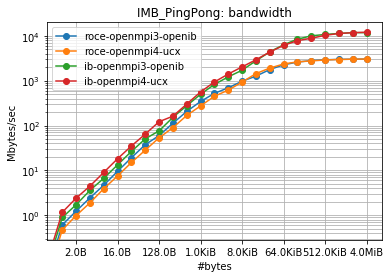

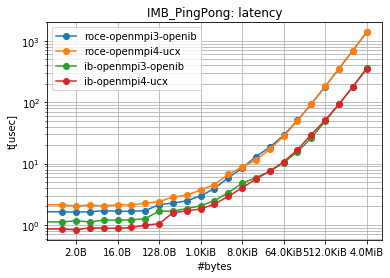

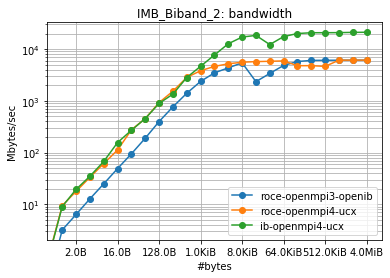

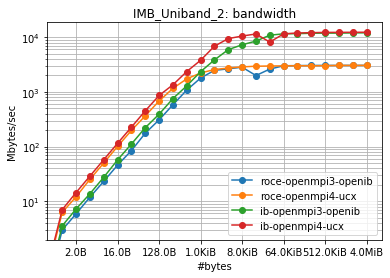

In [10]:
for (test, column, param) in [('IMB_PingPong', 'Mbytes/sec', 'bandwidth'),
                              ('IMB_PingPong', 't[usec]', 'latency'),
                              ('IMB_Biband_2', 'Mbytes/sec', 'bandwidth'),
                              ('IMB_Uniband_2', 'Mbytes/sec', 'bandwidth'),
                             ]:
    
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../output', test=test)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    common, meta_diffs = modules.utils.diff_dicts([modules.utils.parse_path_metadata(p) for p in paths], ignore=['path'])
    
    # load and plot:
    for ix, path in enumerate(paths):
        data = modules.imb.read_imb_out(path)[2] # all use 2x processes
        label = '-'.join(meta_diffs[ix].values())
        plt.plot(data['#bytes'], data[column], 'o-', data=data, label=label)
        
    # format plot:
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
    ax.grid(True, which="both")
    ax.set_xlabel('#bytes')
    ax.set_ylabel(column)
    title = ' '.join(['%s:%s' % (k, v) for (k, v) in common.items()]) # TODO: improve
    ax.set_title('%s: %s' % (test, param))
    ax.legend()

# Max Bandwidth vs Number of Processes per Node

The plots below show the **maximum** bandwidth for tests using varying numbers of processes per node. Results are for the most-recent test on each system/partition/environment combination.

{'alaska-ib-openmpi3-openib-imb': 99.12832,
 'alaska-ib-openmpi4-ucx-imb': 104.1264,
 'alaska-roce-openmpi3-openib-imb': 98.03072,
 'alaska-roce-openmpi4-ucx-imb': 98.032}

IMB_Uniband_*: max_bandwidth (Mbytes/sec)


case,alaska-ib-openmpi3-openib-imb,alaska-ib-openmpi4-ucx-imb,alaska-roce-openmpi3-openib-imb,alaska-roce-openmpi4-ucx-imb
procs_per_node,,,,
1,12089.65,12357.77,3061.16,3062.64
2,12068.59,12344.88,3061.63,3059.87
4,12296.19,12372.05,3062.62,3062.55
8,12389.64,12332.47,3059.80,3063.02
16,12391.04,13015.80,3063.14,3063.03
32,12389.39,12386.81,3063.46,3063.50


{'alaska-ib-openmpi4-ucx-imb': 169.2224,
 'alaska-roce-openmpi3-openib-imb': 196.04512,
 'alaska-roce-openmpi4-ucx-imb': 196.03936}

IMB_Biband_*: max_bandwidth (Mbytes/sec)


case,alaska-ib-openmpi4-ucx-imb,alaska-roce-openmpi3-openib-imb,alaska-roce-openmpi4-ucx-imb
procs_per_node,,,
1,20820.42,6112.92,6117.19
2,21152.80,6115.68,6120.60
4,20233.70,6120.39,6120.24
8,20283.46,6124.03,6113.92
16,20641.11,6124.61,6125.41
32,20921.39,6126.38,6125.76
64,20569.10,6126.41,6126.23


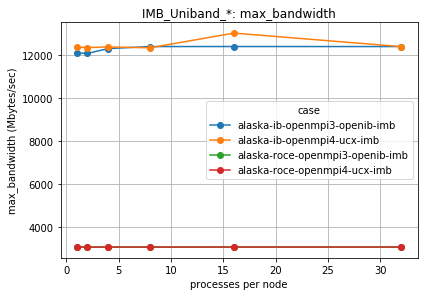

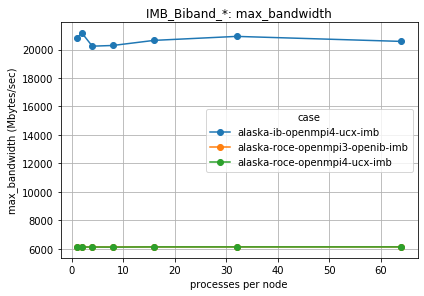

In [27]:
for test in ['IMB_Uniband_*', 'IMB_Biband_*']:
    
    # load perf records:
    perf_records = modules.utils.load_perf_logs('../perflogs', test, '.log')
    
    # calculate number of processes (=tasks):
    perf_records['procs_per_node'] = [int(tn.rsplit('_')[-1]) for tn in perf_records['testname']]
    
    # plot/tabulate:
    for perf_var in ['max_bandwidth']:
        perf_unit = perf_records[perf_records['perf_var'] == perf_var]['perf_unit'].iloc[0] # assumes unique
#         print(perf_unit)
#         print(perf_records)
#         print('---')
        table = modules.plots.tabulate_last_perf_vs(perf_records, 'procs_per_node', perf_var)
        
        # calculate real vs theortical perf, for highest bandwidth in each system/partition/environment:
        Gb_to_MB = 125.0
        max_for_spe = table.max(0).to_dict()
        #print(max_for_spe)
        THEORETICAL = {'alaska-ib-openmpi3-openib-imb': 100 * Gb_to_MB,
                       'alaska-ib-openmpi4-ucx-imb':  100 * Gb_to_MB,
                       'alaska-roce-openmpi3-openib-imb': 25 * Gb_to_MB,
                       'alaska-roce-openmpi4-ucx-imb':  25 * Gb_to_MB,
                      }
        efficiency = dict((spe, 100 * mv / THEORETICAL[spe]) for (spe, mv) in max_for_spe.items())
        pprint(efficiency)
        
        ax = table.plot(grid=True, style='o-')
        ax.set_xlabel('processes per node')
        ax.set_ylabel('%s (%s)' % (perf_var, perf_unit))
        plt.tight_layout()
        ax.set_title('%s: %s' % (test, perf_var))
        
        print()
        print('%s: %s (%s)' % (test, perf_var, perf_unit))
        display(HTML(table.to_html()))
